In [1]:
import numpy as np
import PIL.Image as Image
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
from readPatchOutput import *


repeat = 1
n_pic = 2160
nV1 = 1024
nblock = 5
nE = 768
pixel = '16'
Epick = []
Ipick = []
for i in range(nblock):
    for j in range(nV1):
        if j <nE:
            Epick.append(i*nV1+j)
        else:
            Ipick.append(i*nV1+j)

In [2]:
output_suffix0 = 'static_32pixel_1'
res_suffix = 'minimal-patch'
conLGN_suffix = 'test_lgn' 
conV1_suffix = 'test_v1'
res_suffix = "_" + res_suffix
conLGN_suffix = "_" + conLGN_suffix
conV1_suffix = "_" + conV1_suffix
output_suffix = output_suffix0
_output_suffix = "_" + output_suffix
res_fdr = '/root/autodl-tmp/ljy/resource_static_32pixel/'
setup_fdr = '/root/autodl-tmp/ljy/resource_static_32pixel/'
data_fdr = '/root/autodl-tmp/ljy/data_static_32pixel/'

LGN_V1_sFn = setup_fdr + "LGN_V1_sList" + conLGN_suffix + ".bin"
LGN_V1_idFn = setup_fdr + "LGN_V1_idList" + conLGN_suffix + ".bin"
LGN_spFn = data_fdr + "LGN_sp" + _output_suffix
parameterFn = data_fdr + "patchV1_cfg" +_output_suffix + ".bin"

# prec, sizeofPrec, vL, vE, vI, vR, vThres, gL, vT, typeAcc, nE, nI, sRatioLGN, sRatioV1, frRatioLGN, convolRatio, nType, nTypeE, nTypeI, frameRate, inputFn, _virtual_LGN, tonicDep, noisyDep = read_cfg(parameterFn)
LGN_V1_s = readLGN_V1_s0(LGN_V1_sFn)
LGN_V1_ID, nLGN_V1 = readLGN_V1_ID(LGN_V1_idFn)
# LGN_spScatter = readLGN_sp(LGN_spFn + ".bin", prec = prec)
LGN_V1_idFn = setup_fdr + "LGN_V1_idList" + conLGN_suffix + ".bin"
LGN_V1_ID, nLGN_V1 = readLGN_V1_ID(LGN_V1_idFn) # size为5120
nLGN_V1_E = nLGN_V1[Epick]
output_suffix = 'static_32pixel'

In [3]:
def get_FreqComp(data, ifreq):
    if ifreq == 0:
        raise Exception('just use mean for zero comp')
    ndata = len(data)
    Fcomp = np.sum(data * np.exp(-2*np.pi*1j*ifreq*np.arange(ndata)/ndata))/ndata
    return np.array([np.abs(Fcomp)*2, np.angle(Fcomp, deg = True)])

In [9]:
def generate_file(filename,filename2):
    
    with open(filename) as f:
        sampleSize = np.fromfile(f, 'u4', 1)[0] #一共5120
        sample_t0, sample_t1 = np.fromfile(f, 'f4', 2)#t0是开始时间，t1是结束时间，我一共跑了1s
        nt = np.fromfile(f, 'u4', 1)[0]
        nLGN = np.fromfile(f, 'u4', 1)[0]
        LGN_spike_time = np.fromfile(f, 'u4', nLGN*nt)
        sampleID = np.fromfile(f, 'u4', sampleSize)#id排序是顺序的
        sample_spikeCount = np.fromfile(f, 'u4', sampleSize)
    LGN_spike_time = LGN_spike_time.reshape((nt,nLGN)).T
    
    V1_input_pre = np.zeros((sampleSize,nt))
    for i in range(sampleSize):
        tmp_id = sampleID[i]
        nLGN_ = LGN_V1_ID[tmp_id].size
        for j in range(nLGN_):
            V1_input_pre[i] += LGN_spike_time[LGN_V1_ID[tmp_id][j]]*LGN_V1_s[tmp_id][j]
            
    TF = 8.0
    tTF = 1000/TF
    dt = (sample_t1-sample_t0)/nt
    cycle = int(tTF/dt)
    F0_ls = []
    F1_ls = []
    for tsp in V1_input_pre:
        F0 = np.mean(tsp)
        tsp = np.mean(tsp.reshape((cycle,-1)),axis=1)
        tsp = np.mean(tsp.reshape((-1,25)),axis=0)
        F1 = get_FreqComp(tsp, 1)[0]
        F0_ls.append(F0)
        F1_ls.append(F1)
    F0_ls = np.array(F0_ls).astype('f4')
    F1_ls = np.array(F1_ls).astype('f4')
    
    with open(filename2,'wb') as f:
        np.array([sampleSize]).astype('u4').tofile(f)
        np.array([sample_t0, sample_t1]).astype('f4').tofile(f)
        sampleID.astype('u4').tofile(f)
        sample_spikeCount.astype('u4').tofile(f)
        F0_ls.astype('f4').tofile(f)
        F1_ls.astype('f4').tofile(f)
    

In [10]:
for k in range(1030,n_pic+1):
    filename1 = data_fdr + 'sample_spikeCount_' + output_suffix + '_' + str(k) + '.bin'
    filename2 = data_fdr + 'sample_OutAndInputCount_' + output_suffix + '_' + str(k) + '.bin'    
    generate_file(filename1,filename2)

In [40]:
with open('/root/autodl-tmp/ljy/data_static_32pixel/sample_OutAndInputCount_static_32pixel_24.bin') as f:
    sampleSize = np.fromfile(f,'u4',1)[0]
    sample_t0, sample_t1 = np.fromfile(f, 'f4', 2)
    sample_spikeCount = np.fromfile(f,'u4',sampleSize)
    F0_ls = np.fromfile(f,'f4',sampleSize)
    F1_ls = np.fromfile(f,'f4',sampleSize)    

In [8]:
filename = data_fdr + 'sample_spikeCount_' + output_suffix + '_' + str(k) + '.bin'
with open(filename) as f:
    sampleSize = np.fromfile(f, 'u4', 1)[0] #一共5120
    sample_t0, sample_t1 = np.fromfile(f, 'f4', 2)#t0是开始时间，t1是结束时间，我一共跑了1s
    nt = np.fromfile(f, 'u4', 1)[0]
    nLGN = np.fromfile(f, 'u4', 1)[0]
    LGN_spike_time = np.fromfile(f, 'u4', nLGN*nt)
    sampleID = np.fromfile(f, 'u4', sampleSize)#id排序是顺序的
    sample_spikeCount = np.fromfile(f, 'u4', sampleSize)
LGN_spike_time = LGN_spike_time.reshape((nt,nLGN)).T
print(sampleID)

[   0    1    2 ... 4861 4862 4863]


In [13]:
def generate_input(LGN_spike_time,sampleSize,nt,sampleID):
    with open(data_fdr + 'sample_spikeCount_' +  output_suffix0+'_1000' + '.bin') as f:
        sampleSize = np.fromfile(f, 'u4', 1)[0] #一共5120
        sample_t0, sample_t1 = np.fromfile(f, 'f4', 2)#t0是开始时间，t1是结束时间，我一共跑了1s
        nt = np.fromfile(f, 'u4', 1)[0]
        nLGN = np.fromfile(f, 'u4', 1)[0]
        LGN_spike_time = np.fromfile(f, 'u4', nLGN*nt)
        sampleID = np.fromfile(f, 'u4', sampleSize)#id排序是顺序的
        sample_spikeCount = np.fromfile(f, 'u4', sampleSize)
    LGN_spike_time = LGN_spike_time.reshape((nt,nLGN)).T
    V1_input_pre = np.zeros((sampleSize,nt))
    for i in range(sampleSize):
        tmp_id = sampleID[i]
        nLGN_ = LGN_V1_ID[tmp_id].size
        for j in range(nLGN_):
            V1_input_pre[i] += LGN_spike_time[LGN_V1_ID[tmp_id][j]]*LGN_V1_s[tmp_id][j]
    TF = 8.0
    tTF = 1000/TF
    dt = (sample_t1-sample_t0)/nt
    cycle = int(tTF/dt)
    F0_ls = []
    F1_ls = []
    for tsp in V1_input_pre:
        F0 = np.mean(tsp)
        tsp = np.mean(tsp.reshape((cycle,-1)),axis=1)
        tsp = np.mean(tsp.reshape((-1,25)),axis=0)
        F1 = get_FreqComp(tsp, 1)[0]
        F0_ls.append(F0)
        F1_ls.append(F1)
    return V1_input_pre

In [15]:
V1_input_pre = generate_input(LGN_spike_time,sampleSize,nt,sampleID)

In [16]:
V1_input_pre.shape

(3840, 40000)

In [31]:
tsp

array([0.06216467, 0.07299539, 0.07621426, 0.06337274, 0.06370334,
       0.06723934, 0.07181697, 0.06943953, 0.07380644, 0.05934473,
       0.0715493 , 0.06903837, 0.07055607, 0.07046486, 0.06643388,
       0.06612927, 0.07279353, 0.06789947, 0.07030799, 0.06708168,
       0.07546144, 0.07470128, 0.07445811, 0.06449145, 0.07561348])

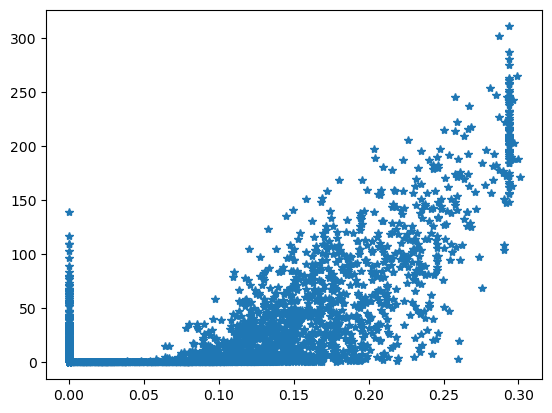

In [30]:
plt.plot(F0_ls,sample_spikeCount,'*')